In [1]:
import ibmos2spark
from pyspark.sql.functions import count,countDistinct
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
spark = SparkSession.builder.getOrCreate()
plt.style.use('ggplot')

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': 'Mah02bEi7GKj9hczaiL-NL7wB1ZrY7LfQx-6-TpVvu3W',
    'service_id': 'iam-ServiceId-b028ce9d-a803-48bc-bdc5-d57d88989644',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'}

configuration_name = 'os_9e785eb379d44200ba4fa10da519fc98_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')
df = spark.read\
  .option('header', 'true')\
  .csv(cos.url('HLL_APPRX_REVIEWER_PRODUCT_processed.csv.gz', 'amazonreviews-donotdelete-pr-qdqutmdfrupodw'))
df.take(5)

[Row(experimentNum='1', runtime='145.8865990638733', thread='1', emitNum='1', estimate='1.0', item='0027426556'),
 Row(experimentNum='1', runtime='145.8865990638733', thread='1', emitNum='1', estimate='1.0', item='0029127408'),
 Row(experimentNum='1', runtime='145.8865990638733', thread='1', emitNum='1', estimate='5.000000049670538', item='0025005405'),
 Row(experimentNum='1', runtime='145.8865990638733', thread='1', emitNum='1', estimate='3.000000014901161', item='0007237677'),
 Row(experimentNum='1', runtime='145.8865990638733', thread='1', emitNum='1', estimate='3.000000014901161', item='0030265665')]

In [2]:
schema = StructType([
    StructField("user", StringType(), True),
    StructField("product", StringType(), True),
    StructField("rating", DoubleType(), True),
    StructField("timestamp", IntegerType(), True)])
exact_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .schema(schema)\
  .load(cos.url('ratings.csv', 'amazonreviews-donotdelete-pr-qdqutmdfrupodw'))
exact_data.take(5)

[Row(user='AH2L9G3DQHHAJ', product='0000000116', rating=4.0, timestamp=1019865600),
 Row(user='A2IIIDRK3PRRZY', product='0000000116', rating=1.0, timestamp=1395619200),
 Row(user='A1TADCM7YWPQ8M', product='0000000868', rating=4.0, timestamp=1031702400),
 Row(user='AWGH7V0BDOJKB', product='0000013714', rating=4.0, timestamp=1383177600),
 Row(user='A3UTQPQPM4TQO0', product='0000013714', rating=5.0, timestamp=1374883200)]

In [3]:
df.createOrReplaceTempView("results")
max_emit_num = spark.sql("SELECT item,MAX(emitNum) as emitNum FROM results GROUP BY item")

gr = exact_data.groupBy("product").agg(countDistinct("user").alias('count')).orderBy('count',ascending=False)
gr.show()

+----------+-----+
|   product|count|
+----------+-----+
|B0054JZC6E|25368|
|B00FAPF5U0|24024|
|B009UX2YAC|23956|
|0439023483|21398|
|030758836X|19867|
|B0051VVOB2|19529|
|B005SUHPO6|18688|
|B00G5LQ5MU|18645|
|B0074BW614|18244|
|B000GF7ZRA|17948|
|B00DR0PDNE|16454|
|B0064X7B4A|16239|
|B00DJFIMW6|16221|
|B00I8Q77Y0|15601|
|B00992CF6W|15294|
|B00AREIAI8|15080|
|B00AWH595M|14393|
|B005ZXWMUS|14310|
|B007WTAJTO|14172|
|0439023513|14114|
+----------+-----+
only showing top 20 rows



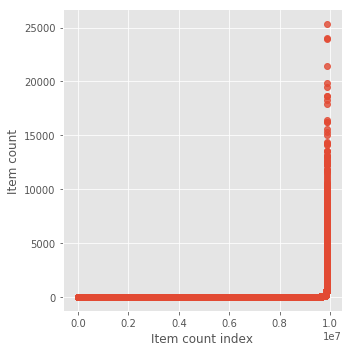

In [4]:
df_counts = gr.select('count').orderBy('count',ascending=True).toPandas()
ax = sns.lmplot( x="index", y="count", data=df_counts.reset_index(), fit_reg=False)
plt.xlabel('Item count index')
# Set y-axis label
plt.ylabel('Item count')
plt.show()

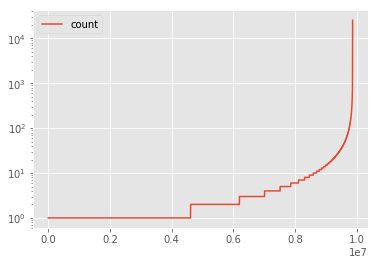

In [5]:
df_counts.plot(logy=True, logx=False)
plt.rcParams["figure.figsize"] =(10,10)

In [6]:
distinct_keys = exact_data.agg(countDistinct("product"))
distinct_keys.show()

+-----------------------+
|count(DISTINCT product)|
+-----------------------+
|                9874210|
+-----------------------+



In [38]:
experiment1 = df.filter(df['experimentNum'] == 1)
experiment1.createOrReplaceTempView("experiment1")
experiment1 = spark.sql("SELECT experimentNum,runtime,thread,a.emitNum,estimate,a.item as item FROM experiment1 AS a INNER JOIN (SELECT item, max(emitNum) AS emitNum FROM experiment1 GROUP BY item) AS b ON a.item =  b.item AND a.emitNum = b.emitNum ORDER BY estimate DESC")
df_compare1 = experiment1.join(gr, experiment1.item == gr.product)
df_compare1.createOrReplaceTempView("df_compare1")
diff1 = spark.sql('SELECT item,round(CAST(estimate AS Integer)) as estimate,count, estimate - count as diff, ROUND((100.0*ABS(estimate - count)) / count,3)as diff_percent FROM df_compare1 ORDER BY count DESC')
diff1.show()


+----------+--------+-----+-------------------+------------+
|      item|estimate|count|               diff|diff_percent|
+----------+--------+-----+-------------------+------------+
|0439023483|   20682|21398| -715.5910258926779|       3.344|
|030758836X|   25159|19867|  5292.431784750104|      26.639|
|0439023513|   13393|14114| -720.0490876470303|       5.102|
|0385537859|   14891|12973| 1918.3244300627466|      14.787|
|0007444117|   13221|12629|  592.4854853029574|       4.691|
|0375831002|   18511|12571|  5940.346647689654|      47.254|
|038536315X|   10923|12564|-1640.7375575881342|      13.059|
|0345803485|   11069|12290|-1220.7931198365986|       9.933|
|0316055433|   10896|11746| -849.2276909484117|        7.23|
|0849922070|   11275|10424|  851.0416493932826|       8.164|
|0007442920|   13221|10172|  3049.087186903811|      29.975|
|0345803493|   10658| 9980|  678.9159871245902|       6.803|
|0399159347|   15344| 9906|  5438.852723883643|      54.905|
|0345803507|    6793| 96

In [10]:
diff1.describe('diff', 'diff_percent').show()

+-------+--------------------+------------------+
|summary|                diff|      diff_percent|
+-------+--------------------+------------------+
|  count|             2322221|           2322221|
|   mean|0.033098969429003006|2.0709819302297467|
| stddev|  13.621863012480437| 5.828961668721508|
|    min| -3083.6912010958213|               0.0|
|    max|   5940.346647689654|            156.96|
+-------+--------------------+------------------+



In [39]:
pd_diff = diff1.toPandas()

In [40]:
pd_diff_int = pd_diff.head(1000)
pd_diff_int

,item,estimate,count,diff,diff_percent
0,0439023483,20682,21398,-715.591026,3.344
1,030758836X,25159,19867,5292.431785,26.639
2,0439023513,13393,14114,-720.049088,5.102
3,0385537859,14891,12973,1918.324430,14.787
4,0007444117,13221,12629,592.485485,4.691
5,0375831002,18511,12571,5940.346648,47.254
6,038536315X,10923,12564,-1640.737558,13.059
7,0345803485,11069,12290,-1220.793120,9.933
8,0316055433,10896,11746,-849.227691,7.230
9,0849922070,11275,10424,851.041649,8.164


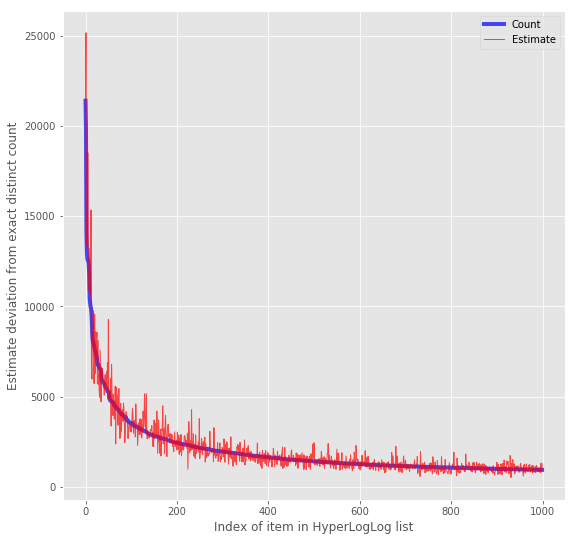

In [44]:
plt.rcParams["figure.figsize"] =(9,9)

plt.plot(pd_diff_int['count'],color='blue', linewidth=4, alpha=0.7,label='Count')
plt.plot(pd_diff_int['estimate'],color='red', linewidth=1, alpha=0.7,label='Estimate')
plt.xlabel('Index of item in HyperLogLog list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact distinct count')
plt.legend()
plt.show()

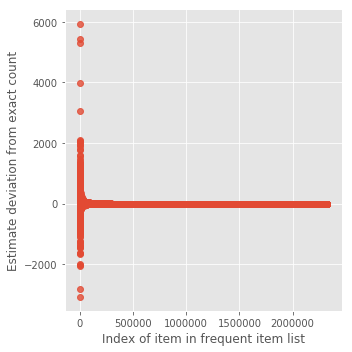

In [42]:
pd_diff['s_index'] = range(1, len(pd_diff) + 1)
ax = sns.lmplot( x="s_index", y="diff", data=pd_diff, fit_reg=False)
plt.rcParams["figure.figsize"] =(9,9)
plt.xlabel('Index of item in frequent item list')
# Set y-axis label
plt.ylabel('Estimate deviation from exact count')

plt.show()